In [2]:
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '..')

# for saving
import os

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

from src import setup
# setup.use_gpu()

In [3]:
from src import ( 
    measurements as measure,
    density_matrix as DM,
    simulation as sim,
    orders,
    random_unitary,
    simulation)

In [4]:
identity = DM.Identity(DM.energy_basis(4))

In [5]:
num_iterations = 50
measurments = [measure.extractable_work_of_each_qubit]



num_samples = 10


In [12]:
titles = ["six","five","messenger"]
results_overall = {8:defaultdict(lambda: defaultdict(list)),12:defaultdict(lambda: defaultdict(list)),16:defaultdict(lambda: defaultdict(list))}

for num_qbits in [16]:
    print(f"working on {num_qbits}")
    # orderings
    # gas_orderings = orders.n_random_gas_orders(num_qbits,chunk_sizes = [4 for _ in range(num_qbits//4)],n = num_iterations)
    line_orderings= orders.n_random_line_orders(num_qbits,chunk_sizes = [4 for _ in range(num_qbits//4)],n = num_iterations)
    five_orderings = orders.n_alternating_c5_orders(num_qbits,n = num_iterations)
    messenger_orderings = orders.n_alternating_messenger_orders(num_qbits,n=num_iterations)

    orderings = [line_orderings,five_orderings,messenger_orderings]
    
    initial_pops = [.2 for _ in range(num_qbits)]
    initial_pops[0] = .4

    for i,ordering in enumerate(orderings):
        print(f"working on connectivity {titles[i]}")
                                                     


        results = results_overall[num_qbits]

        results[titles[i]]["pops"] = []
        results[titles[i]]["ex_work"] = []

        for index in range(num_samples):

            sub_unitary = random_unitary.random_unitary_in_subspace(4,2)
            unitary_list = []
            for unitary_index in range(num_qbits):
                piece = DM.tensor([sub_unitary if j==unitary_index else identity for j in range(num_qbits//4)])
                unitary_list.append(piece)
                
            unitary = np.product(unitary_list)

            system = DM.n_thermal_qbits(initial_pops)
            system.change_to_energy_basis()

            data = sim.run(system,
                              measurement_set = measurments,
                              num_iterations = num_iterations,
                              orders = ordering,
                              Unitaries = unitary
                              )[0];

            if index %1==0: print(index)

            # results[titles[i]]["pops"].append(data[0])
            results[titles[i]]["ex_work"].append(data[0])

working on 16
working on connectivity six
0


KeyboardInterrupt: 

In [34]:
print(np.array([res.get() for res in results_overall[8]["six"]["ex_work"]]))
print(np.array([np.diff(res.get(),1,0)>0 for res in results_overall[8]["six"]["ex_work"]]))
print(np.array([np.sum(np.diff(res.get(),1,0)>0,0) for res in results_overall[8]["six"]["ex_work"]]))
print(np.array([np.sum(np.diff(res.get(),1,0)>0,0)/num_iterations for res in results_overall[8]["six"]["ex_work"]]))

[[[-0.12451126  0.07357688  0.07357688  0.07357688  0.07357688
    0.07357688  0.07357688  0.07357688]
  [-0.10187925  0.04556676  0.04556676  0.04556676  0.04556671
    0.03299874  0.02579121  0.01278042]
  [-0.08769758  0.0235813   0.03854085  0.03818652  0.03752448
    0.02989963  0.00408235  0.00854829]
  [-0.07786494  0.01270231  0.02510632  0.03094556  0.03096188
    0.02558847  0.0099971   0.00592361]]

 [[-0.12451126  0.07357688  0.07357688  0.07357688  0.07357688
    0.07357688  0.07357688  0.07357688]
  [-0.09884257  0.04398713  0.04398713  0.04398713  0.04398713
    0.00259172  0.02702023  0.03142914]
  [-0.08467784  0.03828411  0.03098138  0.03532061  0.03607026
    0.00831435  0.01059029  0.00829598]
  [-0.07316983  0.02173248  0.02087101  0.01771502  0.0223117
    0.01521274  0.02215639  0.00488114]]]
[[[ True False False False False False False False]
  [ True False False False False False False False]
  [ True False False False False False  True False]]

 [[ True False 

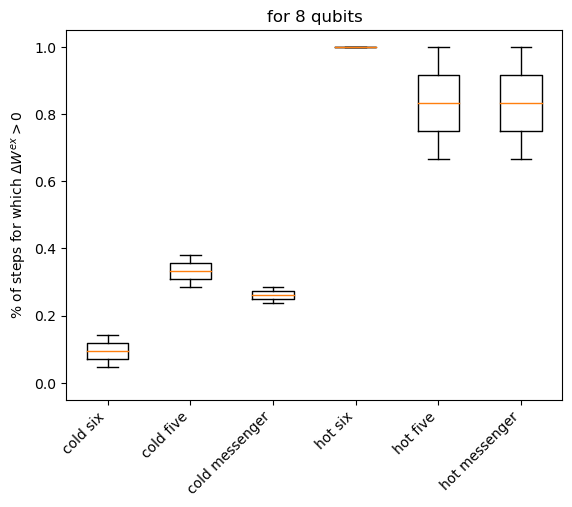

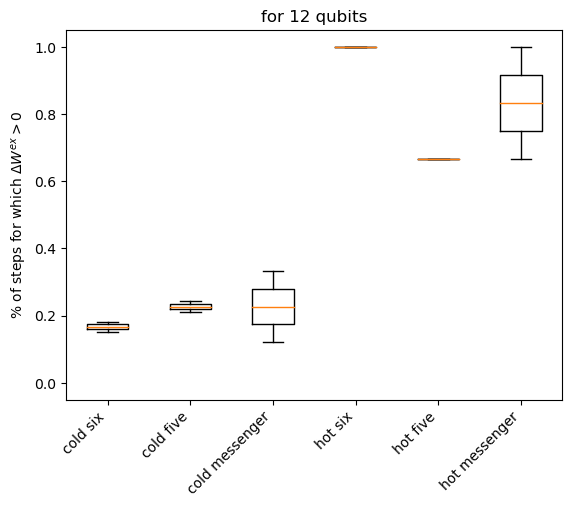

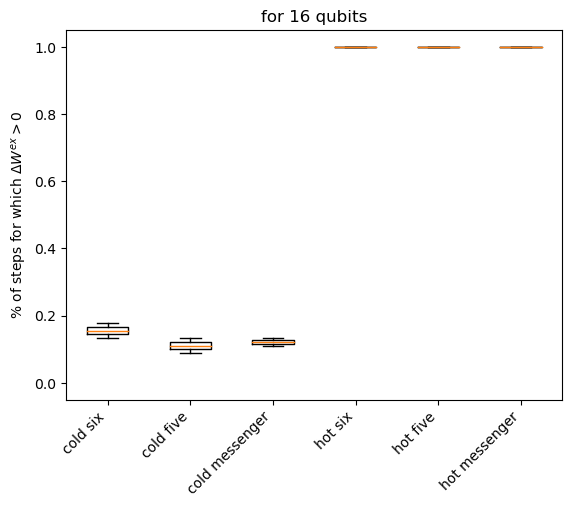

In [37]:

for num_qbits in [8,12,16]:

    processed_hot =  defaultdict(list)
    processed_cold =  defaultdict(list)
    results =  results_overall[num_qbits]
    for connectivity in results:
        processed_samples = np.array([np.sum(np.diff(res.get(),1,0)>0,0)/num_iterations for res in results[connectivity]["ex_work"]])
        processed_hot[connectivity] = processed_samples[:,0]
        processed_cold[connectivity] = np.mean(processed_samples[:,1:],1).flatten()

    labels = ["cold " + key for key in processed_cold.keys()]+["hot " + key for key in processed_hot.keys()]
    
    
    fig, ax = plt.subplots()
    ax.boxplot(list(processed_cold.values())+list(processed_hot.values()),labels = labels)
        
    ax.set_ylabel("% of steps for which $\Delta W^{ex}>0$")
    ax.set_ylim(-.05,1.05)
    plt.xticks(rotation=45, ha="right")
    plt.title(f"for {num_qbits} qubits")
